<a href="https://colab.research.google.com/github/EmilGauti/flog/blob/master/flog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")



1.1.   (klára/laga features) reikna auðkenni á minni tímabútum og skeyta því saman í lengri auðkennavigur 

1.2.   prófa fleiri flokkara (svm, tré), tuna parametra, prófa með basic test-train á öllum gögnum

1.3.   Fá út accuracy, sens og spec (ruglingsfylki) (kannski matthews líka?)



2.1.   Klára patient specific skriftu (kasta út acc, spec og sens á alla og svo meðaltal)

2.2.   Keyra hana með besta (eða öllum) flokkaranum



3.1.   Fourier myndadót eins og í grein úr pósti

3.2.   Tauganet á það



4.1   (Vega mikilvægi features ef við notum tré)

In [3]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#input: 
#filename: name of file to read from
#shape: dimension of resulting array                   
def read3DArrayFromFile(fileName,shape):                      
    data = np.loadtxt(fileName, dtype = 'float32')
    data = data.reshape(shape)
    return(data)

nrPatients = 24
fs = 256 # Sampling rate
nrChannels = 23
seizureLength = 14 # seconds
nrSeizures = 170
fRange = 129
M = 16
fLowerLimit = 0.5
fUpperLimit = 25
dataShape = (nrSeizures,nrChannels,seizureLength*fs)

# Read raw data
seizureData = read3DArrayFromFile('seizureChunks14.txt',dataShape)
nonSeizureData = read3DArrayFromFile('nonSeizureChunks14.txt',dataShape)
allData = np.concatenate((seizureData,nonSeizureData),axis = 0)

In [24]:
# FLOKKARARw

tlength = 8 # calculate features for each time interval of tlength seconds (must divide seizureLength) 11sec skilar besta

[X,y] = create_data_matrix(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit, seizureLength, tlength, hjorth = True)
print("X:", X.shape)
print("y:", y.shape)

print('Logistic Regression classifier trained on data from pooled subjects')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf=LogisticRegression(max_iter  = 200)
clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
###############
#
#####################
#Emil að bæta við classifierum
#Setti líka þá classifiera sem voru hér
#í meira compact format
#####################
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


La = linear_model.Lasso()
Et = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
Rf = RandomForestRegressor(n_jobs=-1, n_estimators=500)
Gbt = GradientBoostingRegressor()
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))#kannski má ekki vera max_depth>1
clf_tree = DecisionTreeClassifier(random_state=0)      
clf_svm = svm.SVC()
clf_LR=LogisticRegression(max_iter  = 200)


name = [La,Et,Rf,Gbt,clf_tree,clf_svm,clf_LR,clf_ada]
names_s = ['La','Et','Rf','Gbt','clf_tree', 'clf_svm', 'clf_LR', 'clf_ada']
for i in range(len(name)):
    name[i].fit(X_train,y_train)
    print(names_s[i]+' score:' , name[i].score(X_test,y_test))

X: (340, 2622)
y: (340,)
Logistic Regression classifier trained on data from pooled subjects
Accuracy:  0.6823529411764706
La score: 0.04882434301257888
Et score: 0.45421092530657714
Rf score: 0.3880553400222963
Gbt score: 0.37160569596903925
clf_tree score: 0.7529411764705882
clf_svm score: 0.4588235294117647
clf_LR score: 0.6823529411764706
clf_ada score: 0.7411764705882353


In [28]:
for tlength in range(1,13):
    clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
    [X,y] = create_data_matrix(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit, seizureLength, tlength, hjorth = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    clf_ada.fit(X_train,y_train)
    print(tlength,clf_ada.score(X_test,y_test))

1 0.5529411764705883
2 0.6705882352941176
3 0.6235294117647059
4 0.6705882352941176
5 0.7529411764705882
6 0.7058823529411765
7 0.7647058823529411
8 0.8
9 0.8117647058823529
10 0.8117647058823529
11 0.8470588235294118
12 0.8941176470588236


In [12]:
##########Reynum að nota Grid-search til að tune-a parametra
from sklearn.model_selection import GridSearchCV
clf_ada2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
parametersAda = {'n_estimators' : [50, 100, 25], 
              'learning_rate':[0.1,0.4,0.7,1,1.5]}
clf_ada_GS = GridSearchCV(clf_ada2, parametersAda, cv=5)
clf_ada_GS.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 25], 'learning_rate': [0.1, 0.4, 0.7, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print('Score: ', clf_ada_GS.score(X_test,y_test))
print(print('Bestu parametrar:',clf_ada_GS.best_params_))
### Keyrsla á gamla forritinu áður en Lxi var búinn að mixxa
### Score:  0.8
###Bestu parametrar: {'learning_rate': 1.5, 'n_estimators': 100}


Score:  0.8
Bestu parametrar: {'learning_rate': 1.5, 'n_estimators': 100}
None


Model sensitivity: 0.717391304347826
Model specificity: 0.7692307692307693
Matthews correlation coefficient  0.48500269446689837


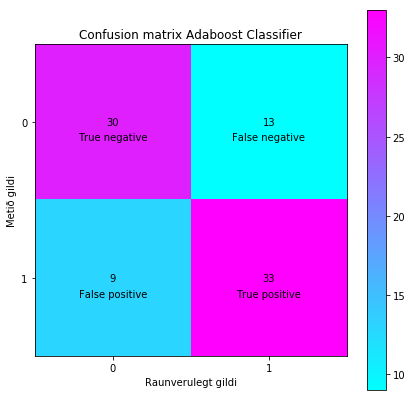

In [25]:
######### CONFUSION MATRIX
from sklearn import metrics
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test,clf_ada.predict(X_test))
plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='cool')
plt.title('Confusion matrix Adaboost Classifier')
plt.xlabel('Raunverulegt gildi')
plt.ylabel('Metið gildi')
plt.xticks([0,1])
plt.yticks([0,1])
plt.colorbar()
n = cm.shape[0]
p = cm.shape[1]
blabb = ['True negative','False positive','False negative','True positive']
ind=0
for i in range(n):
    for j in range(p):        
        plt.annotate(str(cm[i,j]),xy=(i,j), 
                     horizontalalignment='center', verticalalignment='center')
        plt.annotate(blabb[ind],xy=(i,j+0.1), horizontalalignment='center'
                     , verticalalignment='center')
        ind=ind+1
sens = cm[1,1]/(cm[1,1] + cm[1,0])
spec = cm[0,0]/(cm[0,0] + cm[0,1])

print('Model sensitivity:', sens)
print('Model specificity:', spec)

print('Matthews correlation coefficient ', metrics.matthews_corrcoef(y_test, clf_ada.predict(X_test)))

In [16]:
# FEATURES overlap

import numpy as np
from scipy import signal

# Hjorth parameters (time domain)
# https://en.wikipedia.org/wiki/Hjorth_parameters
def hjorth_mobility(x):
    num = np.var(np.diff(x))
    den = np.var(x)
    if den > 0:
        return np.sqrt(num / den)
    else:
        return 0.0

def hjorth_parameters(x):
    activity=np.var(x)
    mobility=hjorth_mobility(x)
    if mobility > 0:
        complexity=hjorth_mobility(np.diff(x)) / mobility
    else:
        complexity=0.0
    return np.array([activity, mobility, complexity])

#Calculates power spectral density for an eeg segment
#inputs: 
#signalMat: signal matrix for chunk
#fs: sampling density
#n: number of channels
#outputs: 
#f: frequency
#Pwelch: power spectral density calculated by Welch's method
def psd(signalMat,fs,n,fRange):
    Pwelch = np.zeros((n,fRange))
    for i in range(n):
        F,Pwelch[i,:] = signal.welch(signalMat[i,:],fs,scaling = 'spectrum')
    return(F,Pwelch)

# Absolute band power
# Combined power in M frequency bands
def absolute_power(f, PSD,M,l,h):
    length = (h-l)/M
    power = []
    k = l
    for i in range(M):
        power.append(sum(PSD[np.where((f > k) & (f <= k+length))]))
        k +=length
    return(power)
    
#Relative power of delta, theta, alpha 
#and beta waves for a single channel
def relative_power(f,PSD,M,l,h):
    absPow = absolute_power(f,PSD,M,l,h)
    tot = sum(PSD)
    if tot > 0.0:
        return(absPow/tot)
    else:
        return 0.0

# Calculate relative band power for the whole data set
# THINK: Might want to do the same for absolute power
def relative_power_all(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit):
    dataPSD = np.zeros((nrSeizures*2,nrChannels,fRange))
    for i in range(nrSeizures*2):
        [F,dataPSD[i,:,:]] = psd(allData[i,:,:],fs,nrChannels,fRange)

    dataRelPower = np.zeros((nrSeizures*2,nrChannels,M))
    for i in range(nrSeizures*2):
        for j in range(nrChannels):
            dataRelPower[i,j,:] = relative_power(F,dataPSD[i,j,:],M,fLowerLimit,fUpperLimit)
    return(dataRelPower)
    
def create_data_matrix(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit, seizureLength, tlength, hjorth = True):
    
    assert tlength < seizureLength, 'tlength more than seizureLength'
    numt = seizureLength - tlength
    dataRelPower = np.zeros((nrSeizures*2, nrChannels, M, numt))
    k = 0
    while k+tlength < seizureLength:
        tData = allData[:,:,k:int(k+tlength*fs)]
        dataRelPower[:,:,:,k] = relative_power_all(tData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit)
        k += 1
        
    dataRelPowerFlat = np.zeros((nrSeizures*2,nrChannels*M*numt))
    for i in range(nrSeizures*2):
        dataRelPowerFlat[i,:] = dataRelPower[i,:,:,:].flatten()
        
    if hjorth:
        hjopar = np.zeros((nrSeizures*2,nrChannels,3,numt))
        for i in range(nrSeizures*2):
            for j in range(nrChannels):
                k = 0
                while k+tlength < seizureLength:
                    tData = allData[:,:,k:int(k+tlength*fs)]
                    hjopar[i,j,:,k] = hjorth_parameters(tData[i,j,:])
                    k += 1
                    
        hjoparflat = np.zeros((nrSeizures*2,nrChannels*3*numt))
        for i in range(nrSeizures*2):
            hjoparflat[i,:] = hjopar[i,:,:,:].flatten()
        dataRelPowerFlat = np.c_[dataRelPowerFlat, hjoparflat]
    
    
    X = dataRelPowerFlat
    y = np.concatenate((np.repeat(1,nrSeizures),np.repeat(0,nrSeizures)))
        
    return(X,y)


In [ ]:
# PATIENT SPECIFIC

# -*- coding: utf-8 -*-

# Patient-specific classifier

# Pre: Execute main.py

import ast

def fixIndex(i):
    if i < 10:
        i = '0'+str(i)
    return(str(i))

nonSeizureFileNames = open('nonSeizureFileNames.txt', 'r')
nonSeizureFileNames = nonSeizureFileNames.read().split('\n')

with open('seizureDict.txt', 'r') as f:
    s = f.read()
    seizureDict = ast.literal_eval(s)

patientResults = np.zeros((nrPatients+1, 6))

for testPatient in range(1,nrPatients+1):
    #gets index of seizures that belong to testPatient (+nrSeizures since seizure chunks are first in allData)
    prefix = 'chb'+fixIndex(testPatient)
    nonSeizIndices = [i+nrSeizures for i, s in enumerate(nonSeizureFileNames) if s.startswith(prefix)]
    testPatientKeys = [i for i in seizureDict.keys() if i.startswith(prefix)]
    k = 0
    seizIndices = []
    for key in seizureDict:    
        for i in range(len(seizureDict[key])):
            if key in testPatientKeys:
                seizIndices.append(k)
            k = k+1

    patientResults[testPatient-1,:3] = [testPatient, len(seizIndices), len(nonSeizIndices)]
    
    X_test = np.concatenate((X[seizIndices,:],X[nonSeizIndices,:]),axis = 0)
    y_test = np.concatenate((y[seizIndices],y[nonSeizIndices]))
    X_train = np.delete(X, nonSeizIndices, axis=0)
    X_train = np.delete(X_train, seizIndices, axis=0)
    y_train = np.delete(y,nonSeizIndices)
    y_train = np.delete(y_train,seizIndices)
    # THINK: Collect statistics on seizure/nonseizure
    
    # Classify individual patient
    # Insert code here ...
    clf=LogisticRegression(max_iter = 200)
    clf.fit(X_train, y_train)
    patientResults[testPatient-1, 3] = clf.score(X_test, y_test)

patientResults[-1, 3] = np.mean(patientResults[:,3])

dash = '-' * 120
print(dash)
print('{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}'.format('Patient', '# Seizures', '# non Seizures', 'Accuracy', 'Sensitivity', 'Specificity'))
print(dash)
for i in range(patientResults.shape[0]-1):
    print('{:^15d}{:^15d}{:^15d}{:^15f}{:^15f}{:^15f}'.format(int(patientResults[i,0]), int(patientResults[i,1]), int(patientResults[i,2]), patientResults[i,3], patientResults[i,4], patientResults[i,5]))
print(dash)
print('{:^15s}{:^15s}{:^15s}{:^15f}{:^15f}{:^15f}'.format('MEAN', '', '', patientResults[-1, 3], patientResults[-1, 4], patientResults[-1, 5]))

In [ ]:
print('Mean accuracy:', np.quantile(scores, 0.5))

In [151]:
seglength = 2
stepsize = 1

freq = int(fs*seglength / 2) + 1
time = int(seizureLength / stepsize)-1

spectroData = np.zeros((nrSeizures*2, freq, time, nrChannels))

for i in range(nrSeizures*2):
    for j in range(nrChannels):
        Sx = signal.spectrogram(allData[i, j, :], fs = fs, nperseg = fs*seglength, noverlap = fs*(seglength - stepsize))[2]
        spectroData[i, :, :, j] = 10 * np.log10(Sx)


In [186]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.callbacks import EarlyStopping


X_train, X_test, y_train, y_test = train_test_split(spectroData, y, test_size=0.25, random_state=42)

# Convert to 32-bit floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#print(X_train[0,:10,:10,0])
#print(X_train[1,:10,:10,0])
print(X_train.shape)
num_classes = 1
num_epochs = 100
batch_size = 50
input_shape = X_train.shape[1:]

# set up early stopping
es = EarlyStopping(monitor='val_acc',
                   min_delta=0,
                   patience=2,
                   verbose=0, mode='auto')

nn = Sequential([ 
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape = input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same"),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same"),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid') ])

nn.summary()

nn.compile(loss='binary_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

history = nn.fit(X_train, y_train,
                  #batch_size=batch_size,
                  epochs=num_epochs,
                 # callbacks = [es],
                  verbose=1,
                  validation_data=(X_test, y_test))
score = nn.evaluate(X_test, y_test, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])


(255, 257, 13, 23)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_222 (Conv2D)          (None, 257, 13, 32)       6656      
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 257, 13, 32)       9248      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 128, 6, 32)        0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 128, 6, 64)        18496     
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 128, 6, 64)        36928     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 64, 3, 128)        73

3584
(1000,) (1,)
3.904296875
Audio length: 14.00 seconds


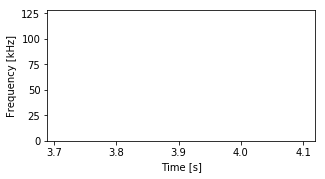

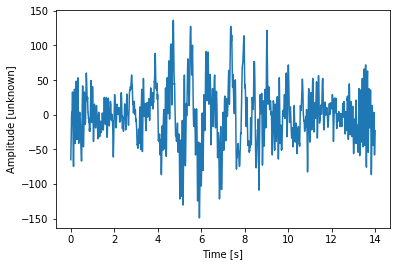

In [141]:
from scipy import signal
data = allData[114,10,:]
N = data.shape[0]
print(N)
rate=256
L = N / rate


freqs, times, Sx = signal.spectrogram(data, fs=rate,
                                      nperseg=1999, noverlap=60,
                                      detrend=False, scaling='spectrum')
print(freqs.shape,times.shape)
print(times[0])
f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
#ax.pcolormesh(times, freqs , Sx, cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');
######
print(f'Audio length: {L:.2f} seconds')

f, ax = plt.subplots()
ax.plot(np.arange(N) / rate, data)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.callbacks import EarlyStopping

n,m,p = allData.shape
fr = np.zeros((n,m,p))
for i in range(n):
  for j in range(m):
    fr[i,j,:] = np.fft.fft(allData[i,j,:])
frFlat = np.zeros((n,m*p))
for i in range(n):
  frFlat[i,:] = fr[i,:,:].flatten()
# Calculate EEG features
X = fr
print("X:", X.shape)
print("y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
num_classes=1
num_epochs = 20
batch_sizeA=300
input_shape = X_train.shape[1:]

# set up early stopping
es = EarlyStopping(monitor='val_acc',
                   min_delta=0,
                   patience=2,
                   verbose=0, mode='auto')

modelA = Sequential([ 
    Conv1D(32, kernel_size=10, activation='relu', padding = "same", input_shape = input_shape),
    Conv1D(32, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Conv1D(64, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(64, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid') ])

modelA.summary()

modelA.compile(loss='binary_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyA=modelA.fit(X_train, y_train,
                  batch_size=batch_sizeA,
                  epochs=num_epochs,
                 # callbacks = [es],
                  verbose=1,
                  validation_data=(X_test, y_test))
scoreA = modelA.evaluate(X_test, y_test, verbose=0)
print('val loss:', scoreA[0])
print('val accuracy:', scoreA[1])
